In [1]:
import numpy as np
import scipy.linalg
from scipy.linalg import eig
import scipy.signal
import scipy.optimize
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import random
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from general_graph_utils import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

## Plotting correlation functions on unicyclic networks

Consider oscillations on a unicyclic network. Our system is initially set up with a fixed force as follows: $k_m = 1.0$, $\mathcal{A} = 200$, $N = 40$, $k_p = k_m \exp{\left(\mathcal{A}/N\right)}$.

We can observe oscillations by computing the correlation function $C_{1,1}(t)$. We are modeling this process in a system where ATP is slowly decreasing, leading to a gradual loss of oscillation coherence. This mimics the conditions observed in experiments conducted by the Yang lab on the cell cycle oscillator in the 

In [3]:
# Create a unicyclic graph in NetworkX

def unicycle_graph(n):
    """
    Generates a reversible unicyclic linear framework graph of size n.
    
    Parameters
    ----------
    n : integer
        the size (or number of vertices) of the graph
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = n
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    for i in range(2,G_size+1):
        u = i-1
        v = i
        G.add_edge(u,v)
        G.add_edge(v,u)
        G_ud.add_edge(u,v)
        
    G.add_edge(G_size,1)
    G.add_edge(1,G_size)
    G_ud.add_edge(1,G_size)
    
    return G, G_ud

In [4]:
# Compute the correlation function from a transition rate matrix

def correlation_function_general(t, W, n):
    exp_Wt = scipy.linalg.expm(W * t) # Compute the matrix exponential e^(Wt)
    #p = np.zeros((1,n))
    #p[0] = 1
    #return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0
    return exp_Wt[0][0]

In [5]:
# Create a 40-state unicicyclic network, as this number of states

N = 40
G, G_ud = unicycle_graph(N)

In [6]:
# Create data structures that contain structural information about the graph (nodes, edges). Define a cycle basis using the NetworkX function cycle_list
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

print(cycle_list)

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 1]]


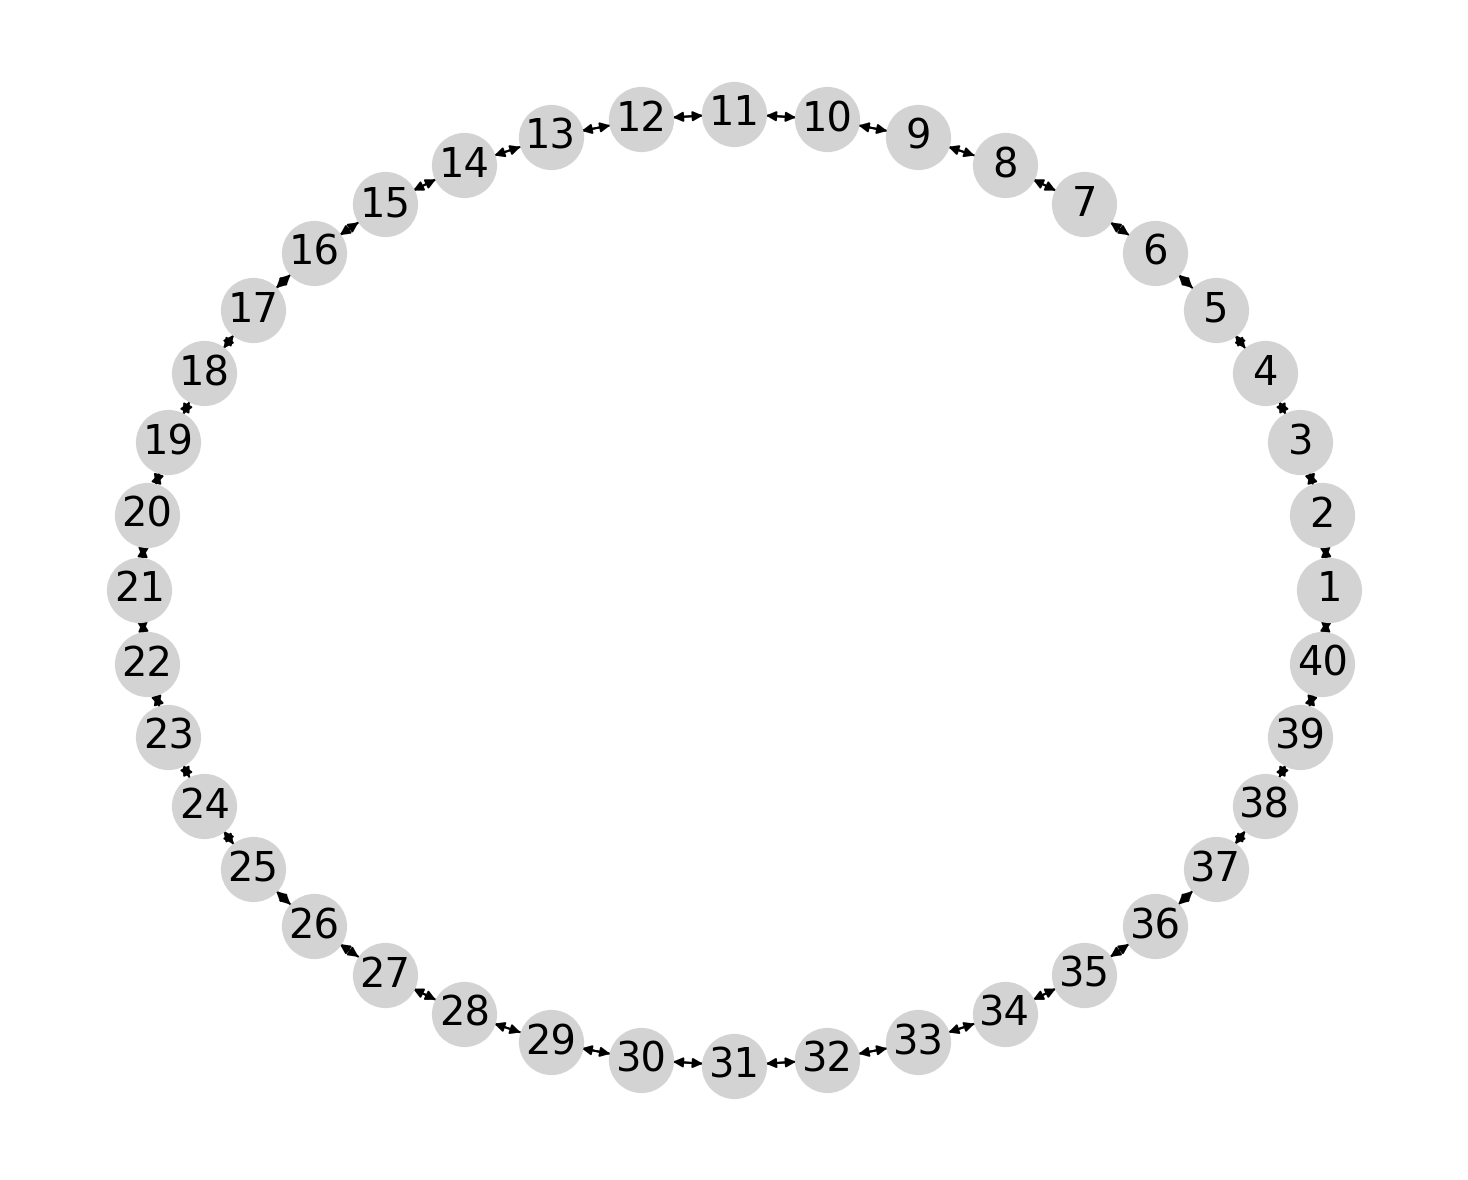

In [7]:
# Draw a picture of the graph

node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=1000, node_color = 'lightgray', font_size=20, font_color='black', font_family='sans-serif')
plt.savefig('40_states.png')

In [8]:
# Determine the forward and reverse rates based off a fixed thermodynamic force (consistent with Barato Seifert)

k_m = 1.0
A = 200
k_p = np.round(k_m*np.exp(A/N),4)
print(k_p)

148.4132


In [9]:
# Assign parameter values to the graph itself and create data structures that contain the edge label information in the same sequence they are listed in in the cycle basis output
# these data structures are used to compute the affinity later

edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

In [10]:
# create a dictionary and a list of all the edge: label pairs

label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
label_list = np.fromiter(label_dict.values(), dtype=float)

In [11]:
# from those, compute the transition matrix (Laplacian matrix)

W = Laplacian_all(edge_list,label_list,node_list)

In [12]:
# Compute the affinity (fixed originally)
affinity = np.round(np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward)),4)
affinity

200.0

In [13]:
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.round(np.abs(np.sort(eigvals)[-2].imag),4)
x_r = np.round(np.abs(np.sort(eigvals)[-2].real),4)

print(x_i, x_r)

# number of coherent oscillations
R = np.round(x_i/x_r,4)
print(R)

23.0605 1.8395
12.5363


In [14]:
# Compute the oscillation coherence from the eigenvalues and eigenvectors

def oscillation_coherence(W):
    eigvals, eigvecs = scipy.linalg.eig(W)
    x_i = np.round(np.abs(np.sort(eigvals)[-2].imag),4)
    x_r = np.round(np.abs(np.sort(eigvals)[-2].real),4)
    
    R = np.round(x_i/x_r,4)
    
    #decay time
    #tau = 1/x_r
    # oscillation period
    #omega = (2*math.pi)/x_i
    
    return R, x_i, x_r

In [15]:
np.round((1/np.tan(math.pi/N))* np.tanh(A / 2*N),4)

12.7062

In [16]:
# compute the upper bound derived by Barato and Seifert
def oscillation_bound(A, N):
    return np.round((1/np.tan(math.pi/N))* np.tanh(A / 2*N),4)

In [17]:
# compute the oscillation coherence and the bound
coherence, x_i, x_r = oscillation_coherence(W)
print(coherence)
bound = oscillation_bound(A, N)
print(bound)

12.5363
12.7062


In [18]:
# Time points for the plot
times = np.linspace(0.1, 5, 500)  # time from 0 to 1.5 with 500 pts
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=40) for t in tqdm(times)]

100%|█████████████████████████████████████████| 500/500 [01:10<00:00,  7.13it/s]


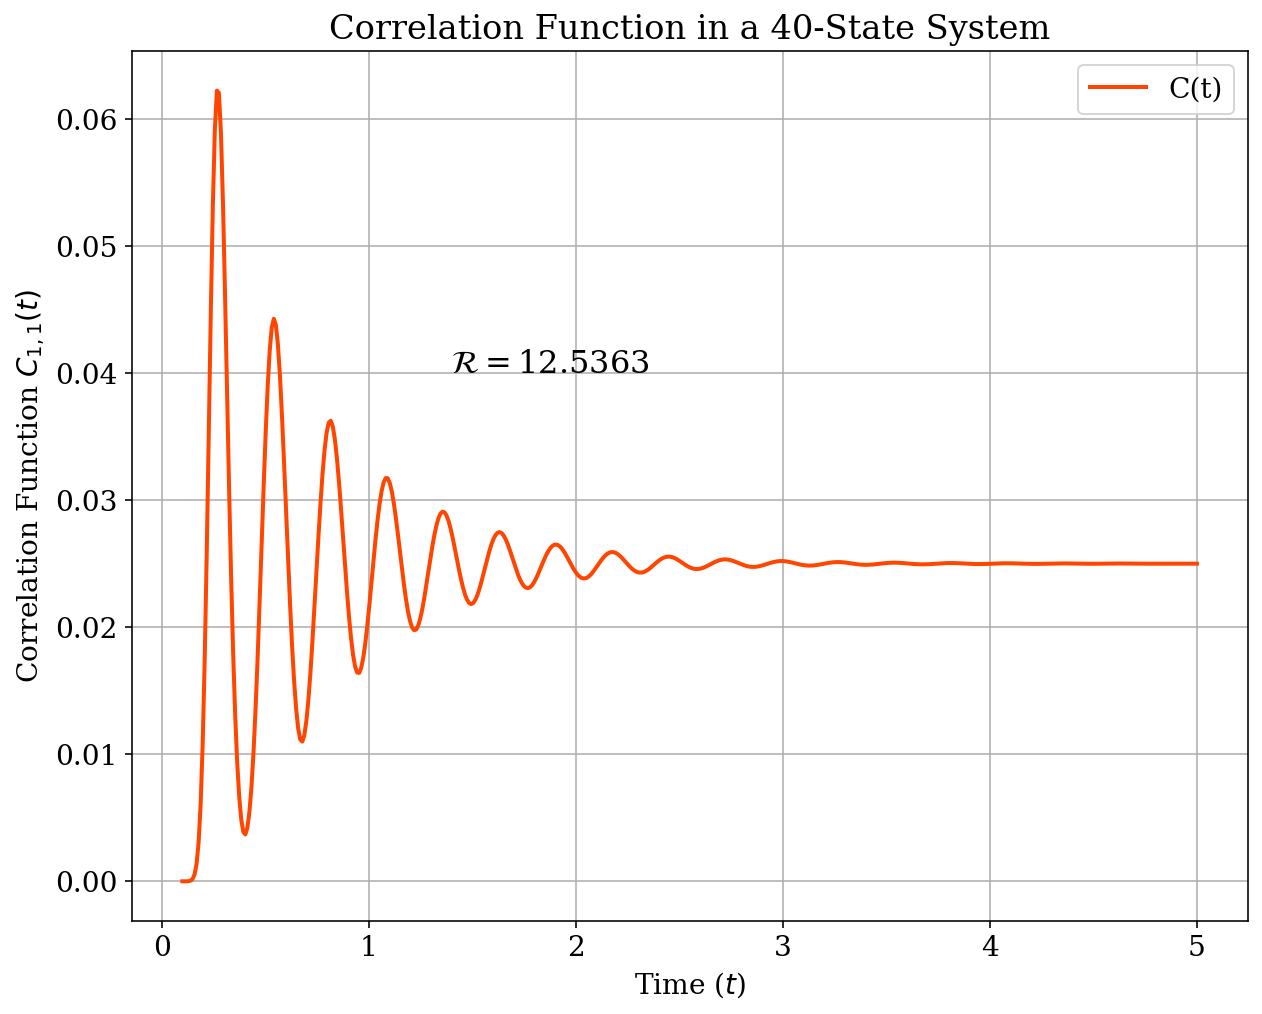

In [19]:
num_states = str(N)
coherence = str(coherence)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize = (10, 8))
plt.text(1.4,0.04, r'$\mathcal{R} =$' + coherence, fontdict=font)
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a '+ num_states +'-State System')
plt.legend()
plt.grid()
plt.savefig('40_states_corr.png')
plt.show()

In [20]:
def gillespie_unicyclic(N, F_init, T_max):
    """
    Simulates a unicyclic chemical reaction network using the Gillespie algorithm.
    
    Parameters:
    N      : int   - Number of states in the cycle
    F_init : float - Initial thermodynamic force
    T_max  : float - Maximum simulation time
    
    Returns:
    times  : list of floats - Time points of state transitions
    states : list of ints   - States visited over time
    """
    # Initialize system state
    state = 0  # Start at state 0
    time = 0.0  # Initialize time
    F = F_init  # Initial thermodynamic force
    
    # Store trajectory
    times = [time]
    states = [state]
    
    while time < T_max:
        # Compute reverse rates dynamically
        k_minus = np.exp(-F / N)
        
        # Compute propensities
        a_plus = 1      # Forward rate
        a_minus = k_minus  # Reverse rate
        
        # Total rate
        a_total = a_plus + a_minus
        
        # Generate time step from exponential distribution
        tau = -np.log(np.random.rand()) / a_total
        time += tau
        
        if time > T_max:
            break
        
        # Determine which reaction occurs
        if np.random.rand() < a_plus / a_total:
            state = (state + 1) % N  # Forward move
        else:
            state = (state - 1) % N  # Reverse move
        
        # Update thermodynamic force dynamically in logarithmic steps
        F *= 1.01  # Modify as needed
        
        # Store results
        times.append(time)
        states.append(state)
    
    return times, states

In [21]:
def plot_trajectory(times, states):
    """
    Plots the state trajectory over time.
    """
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.step(times, states, where='post', label='State Trajectory', linewidth = 2, color='deeppink')
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title('Gillespie Simulation of 40-State Unicyclic Network')
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
# Example usage
N = 40         # Number of states in cycle
F_init = 200  # Initial thermodynamic force
T_max = 100   # Maximum simulation time
times, states = gillespie_unicyclic(N, F_init, T_max)

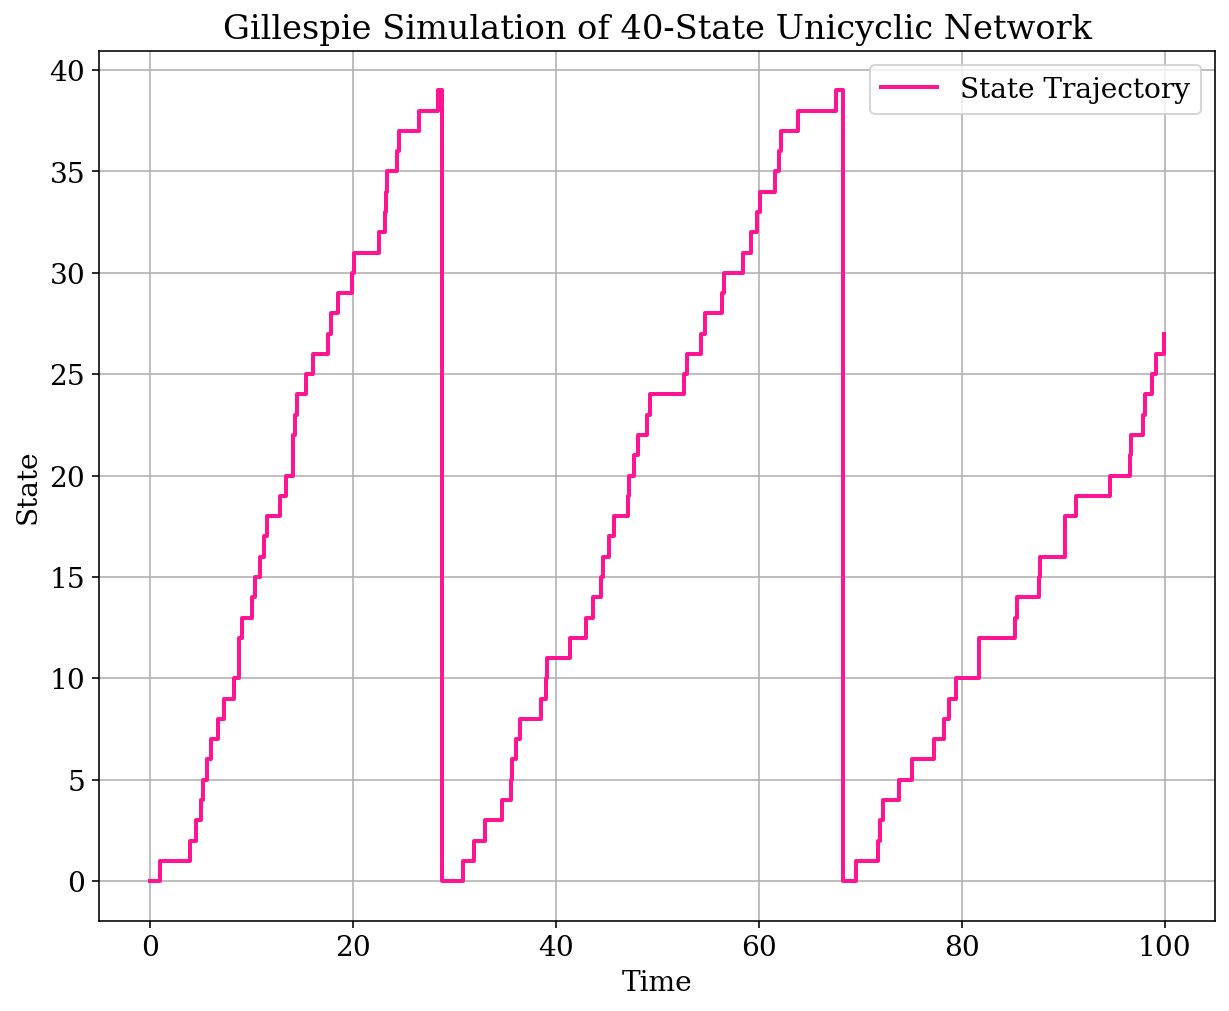

In [23]:
plot_trajectory(times, states)

In [24]:
aff = np.linspace(100,1000,100)
coherences = np.zeros(len(aff))

for i in tqdm(range(len(aff))):
    N = 40
    k_m = 1.0
    A = aff[i]
    k_p = k_m*np.exp(A/N)
    edge_labels_forward = np.array([])
    edge_labels_backward = np.array([])

    for j in range(num_nodes-1):
        u = cycle_list[0][j]
        v = cycle_list[0][j+1]

        G[u][v]['weight'] = k_p
        edge_labels_forward = np.append(edge_labels_forward, k_p)

        G[v][u]['weight'] = k_m
        edge_labels_backward = np.append(edge_labels_backward, k_m)

    G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)
    label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
    label_list = np.fromiter(label_dict.values(), dtype=float)
    W = Laplacian_all(edge_list,label_list,node_list)
    coherence, x_i, x_r = oscillation_coherence(W)
    coherences[i] = coherence

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 396.04it/s]


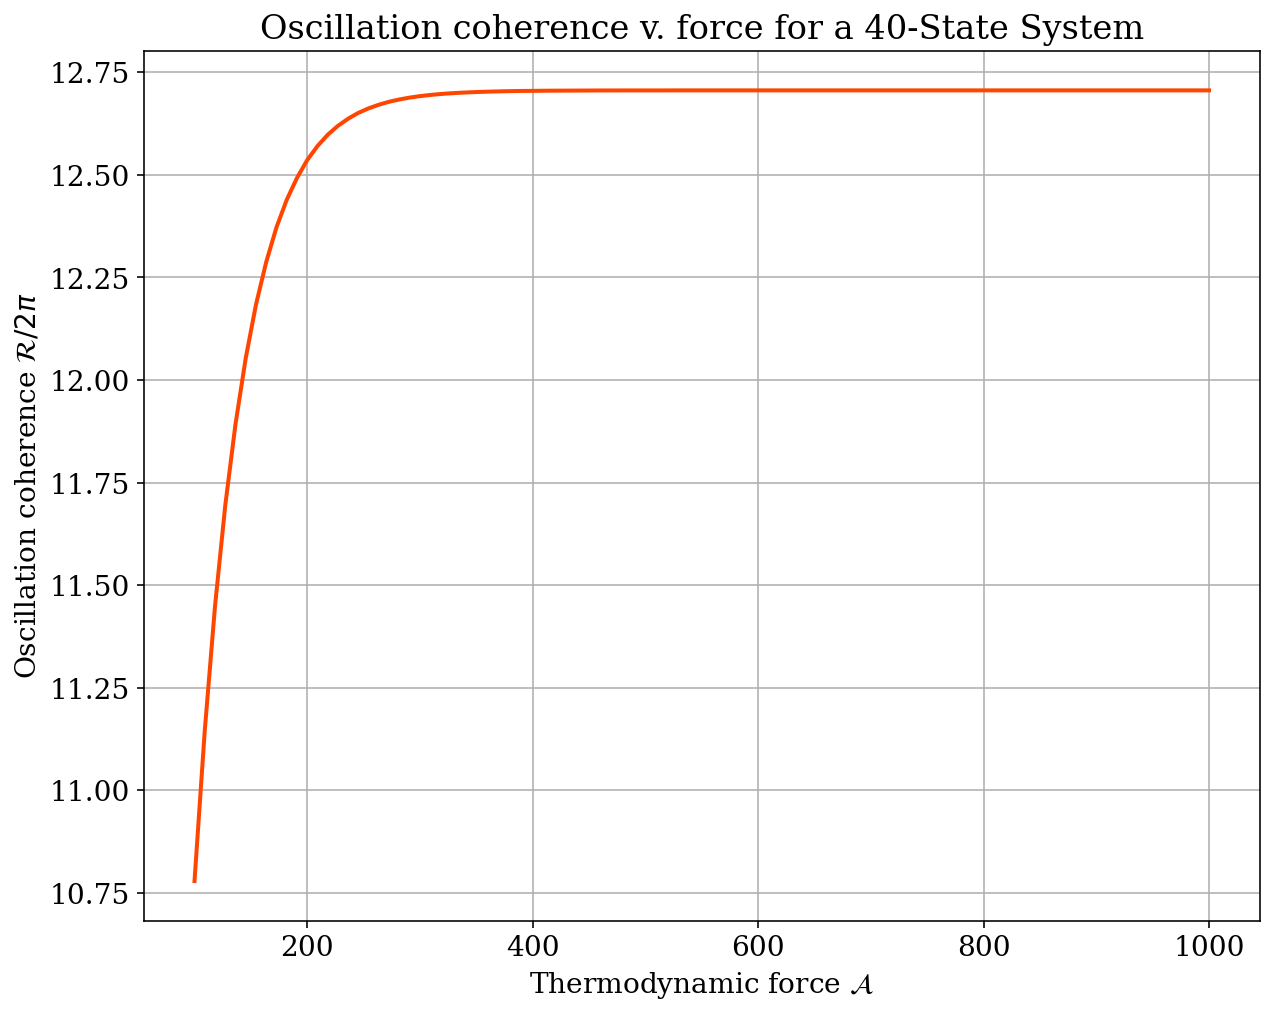

In [25]:
num_states = str(N)

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(aff, coherences, color = "orangered", linewidth=2)
plt.xlabel(r'Thermodynamic force $\mathcal{A}$')
plt.ylabel(r'Oscillation coherence $\mathcal{R}/2 \pi$')
plt.title('Oscillation coherence v. force for a '+ num_states +'-State System')
plt.grid()
plt.show()

## 3D Markovian model

Here, we simulate a stochastic biochemical reaction network for a unicyclic system with 40 states. Each state, labeled $i=(1,\dots,40)$ represents a different chemical configuration. The system dynamics are driven by $ATP$ hydrolysis, $ATP \to ADP + P$. 

We represent this system with a 3D Markov model with state given by $\alpha = \{i, ATP, ADP\}$. A transition in our model between $\eta = \{i, n_{ATP}, n_{ADP}\}$ and $\eta' = \{i-1, n_{ATP} - 1, n_{ADP} + 1\}$ is represented by $ w_{\eta \to \eta'}$.

The key features of the simulation are:

* A forward step represents a chemical transition powered by ATP consumption. ATP decreases by 1 and ADP increases by 1.

$$ w_{\eta \to \eta'} = \begin{cases} i = i \to i+1 \\ ATP = n_{ATP} \to n_{ATP} - 1 \\ ADP = n_{ADP} \to n_{ADP} + 1 \, , \end{cases} $$

* During a backward step, no ATP is produced (ATP reservoir only depletes).

$$ w_{\eta' \to \eta} = \begin{cases} i = i+1 \to i \\ ATP = n_{ATP} - 1 \to n_{ATP} \\ ADP = n_{ADP} + 1 \to n_{ADP} \, . \end{cases} $$

* The rates obey local detailed balance: $k_+ / k_- = \exp{(\delta s)}$ where $\delta s$ is the local entropy production computed from the current ATP, ADP, and P concentrations.
    * The reverse rates $k_-$ are uniformly set to $1.0$.
    * The forward rates $k_+$ are set uniformly to $k_- * e^{\Delta s} = e^{\Delta s}$

To further investigate the relationships between coherence, force, and eigenvalue complexity, we construct a Markov model with state given by $\alpha = \{i, ATP, ADP\}$ where $i = \{1, \dots, 40\}$. 

We impose local detailed balance between each pair of states in our Markovian system. Let $w_{\eta \to \eta'} = k_f n_{ATP}$ and $w_{\eta' \to \eta} = k_r (n_{ADP} +1)$.  From these transition rates, we can impose local detailed balance by setting the force between these two states to equilibrium, 

$$\ln{\left ( \dfrac{w_{\eta \to \eta'}}{w_{\eta' \to \eta}}\right ) } = \dfrac{k_f n_{ATP}}{k_r n_{ADP}} = \dfrac{p^{eq}_{\eta}}{p^{eq}_{\eta'}}\, ,$$

where

$$p^{eq}_{\eta} = \exp{-\beta \left ( E_2 - E_{ATP} n_{ATP} - E_{ADP} n_{ADP} - E_{P_i} n_{P_i}  \right )}\, ,$$

and 

$$p^{eq}_{\eta'} = \exp{-\beta \left ( E_3 - E_{ATP} (n_{ATP}-1) - E_{ADP} (n_{ADP}+1) - E_{P_i} (n_{P_i} +1) \right )}\, .$$

The log of the ratio allows us to cancel many terms,

$$ \ln{\left ( \dfrac{\exp{-\beta \left ( E_2 - E_{ATP} n_{ATP} - E_{ADP} n_{ADP} - E_{P_i} n_{P_i}  \right )}}{\exp{-\beta \left ( E_3 - E_{ATP} (n_{ATP}-1) - E_{ADP} (n_{ADP}+1) - E_{P_i} (n_{P_i} +1) \right )}}\right )} = \beta(\Delta E_{2,3} - E_{ATP} - E_{ADP} - E_{P_i} ) = \Delta E_{2,3} - \Delta E_{ATP,ADP+P_i} \, .$$

This gives us, finally, that,

$$\ln{\left ( \dfrac{k_f n_{ATP}}{k_r n_{ADP}+1} \right )} =\Delta E_{2,3} - \Delta E_{ATP,ADP+P_i} \, , $$

and thus, because $\dfrac{n_{ATP}}{n_{ADP}+1} =\Delta E_{ATP,ADP+P_i}$,

$$\dfrac{k_f}{k_r} = \Delta E_{2,3} \, .$$

We compute 3D stochastic trajectories from this model, and obtain averaged trajectories to see how ATP and coherence change over time.

In [30]:

def compute_entropy_production(n_ATP, n_ADP, n_P):
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        k_plus = n_ATP
        k_minus = n_ADP * n_P
        return np.log(k_plus / k_minus)
    return -np.inf

def compute_initial_entropy(n_ATP, n_ADP, n_P):
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        k_plus = n_ATP
        k_minus = n_ADP * n_P
        return np.log(k_plus / k_minus)
    else:
        return -np.inf

def construct_transition_matrix(N, n_ATP, n_ADP, n_P):
    Q = np.zeros((N, N))
    for i in range(N):
        next_i = (i + 1) % N
        prev_i = (i - 1) % N
        
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        Q[i, next_i] = k_plus if n_ATP > 0 else 0
        Q[i, prev_i] = k_minus if n_ADP > 0 else 0
        Q[i, i] = -(Q[i, next_i] + Q[i, prev_i])
    return Q

def compute_oscillation_coherence(Q):
    eigenvalues = eig(Q, right=False)
    eigenvalues = sorted(eigenvalues, key=lambda x: np.real(x))
    lambda_1 = eigenvalues[-2]  # First nontrivial eigenvalue
    X_R, X_I = np.real(lambda_1), np.imag(lambda_1)
    return X_I / (X_R) if X_R != 0 else np.inf

In [31]:
def gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init, n_P):
    state = 0
    time = 0.0
    n_ATP, n_ADP = n_ATP_init, n_ADP_init

    trajectory = [(time, state, n_ATP, n_ADP)]
    states_visited = [state]
    coherence_record = []
    atp_record = []

    while time < T_max:
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        k_minus = 1.0
        k_plus = k_minus * np.exp(delta_s)

        forward_rate = k_plus if n_ATP > 0 else 0
        reverse_rate = k_minus if n_ADP > 0 else 0

        total_rate = forward_rate + reverse_rate
        if total_rate == 0:
            break

        tau = -np.log(np.random.rand()) / total_rate
        time += tau

        if time > T_max:
            break

        if np.random.rand() < forward_rate / total_rate:
            state = (state + 1) % N
            n_ATP = max(n_ATP - 1, 0)
            n_ADP += 1
        else:
            state = (state - 1) % N
            n_ATP += 1
            n_ADP = max(n_ADP - 1, 0)

        trajectory.append((time, state, n_ATP, n_ADP))
        states_visited.append(state)
        atp_record.append((time,n_ATP))

        # Compute coherence at this step
        Q = construct_transition_matrix(N, n_ATP, n_ADP, n_P)
        coherence = compute_oscillation_coherence(Q)
        coherence_record.append((time, coherence))

    #print("Visited states:", states_visited)
    return trajectory, coherence_record, atp_record

In [32]:
def plot_trajectory_3d(trajectory, atp_threshold=10):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    times, states, atp_levels, adp_levels = zip(*trajectory)

    points = np.array([times, atp_levels, states]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    norm = plt.Normalize(times[0], times[-1])
    lc = Line3DCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(np.array(times))
    lc.set_linewidth(2)

    ax.add_collection3d(lc)

    depleted_indices = [i for i, atp in enumerate(atp_levels) if atp < atp_threshold]
    if depleted_indices:
        ax.scatter(
            [times[i] for i in depleted_indices],
            [atp_levels[i] for i in depleted_indices],
            [states[i] for i in depleted_indices],
            color='red', marker='*', s=100, label='ATP depleted'
        )

    ax.set_xlabel("Time")
    ax.set_ylabel("ATP Levels")
    ax.set_zlabel("State i")
    ax.set_title("3D Trajectory with Time Color and ATP Depletion Markers")

    ax.set_xlim(min(times), max(times))
    ax.set_ylim(min(atp_levels), max(atp_levels))
    ax.set_zlim(min(states), max(states))

    plt.colorbar(lc, ax=ax, label='Time progression')
    if depleted_indices:
        ax.legend()
    plt.show()

def plot_coherence(coherence_record):
    times, coherences = zip(*coherence_record)
    plt.figure()
    plt.plot(times, coherences, '-o')
    plt.xlabel('Time')
    plt.ylabel('Oscillation Coherence (X_I / X_R)')
    plt.title('Oscillation Coherence over Time')
    plt.grid(True)
    plt.show()
    
def plot_atp(atp_record):
    times, atp = zip(*atp_record)
    plt.figure()
    plt.plot(times, atp, '-o')
    plt.xlabel('Time t')
    plt.ylabel('ATP levels [ATP](t)')
    plt.title('ATP levels over Time')
    plt.grid(True)
    plt.show()

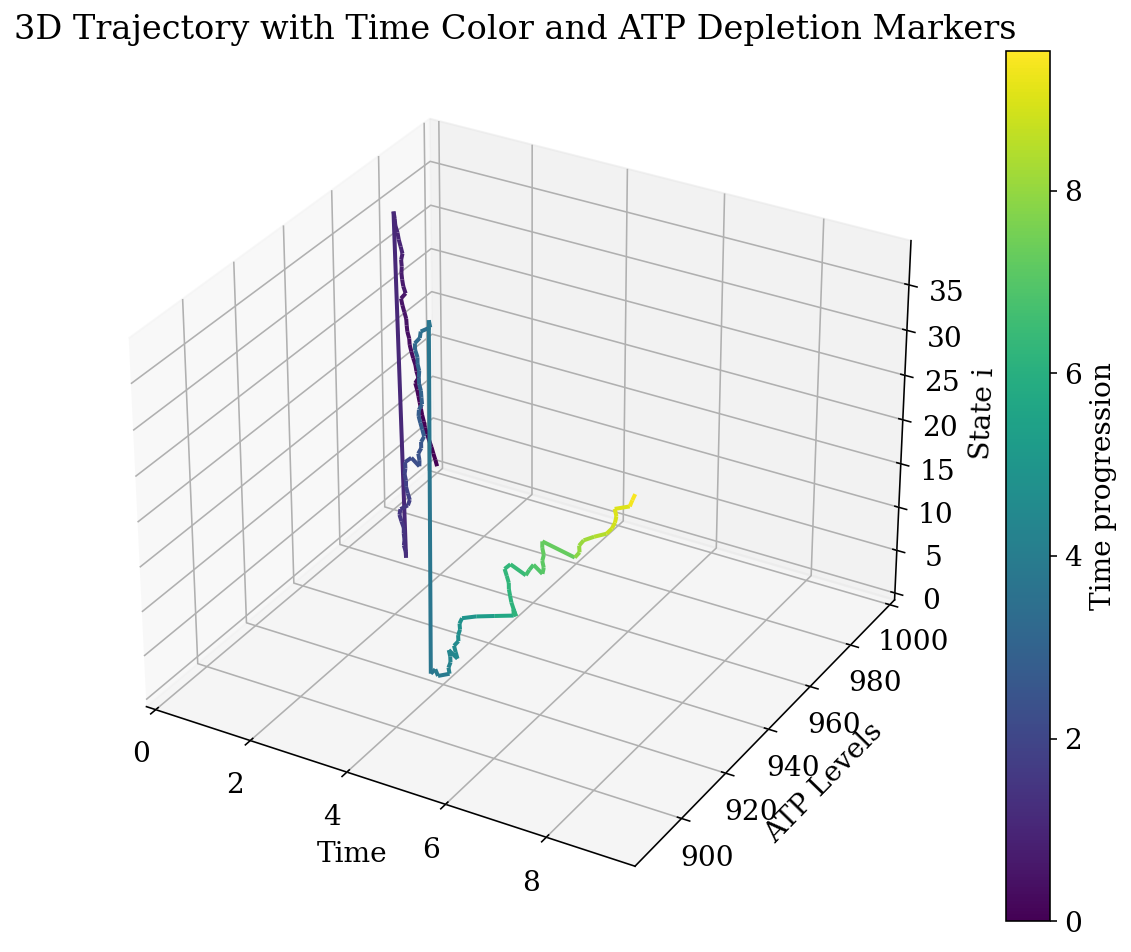

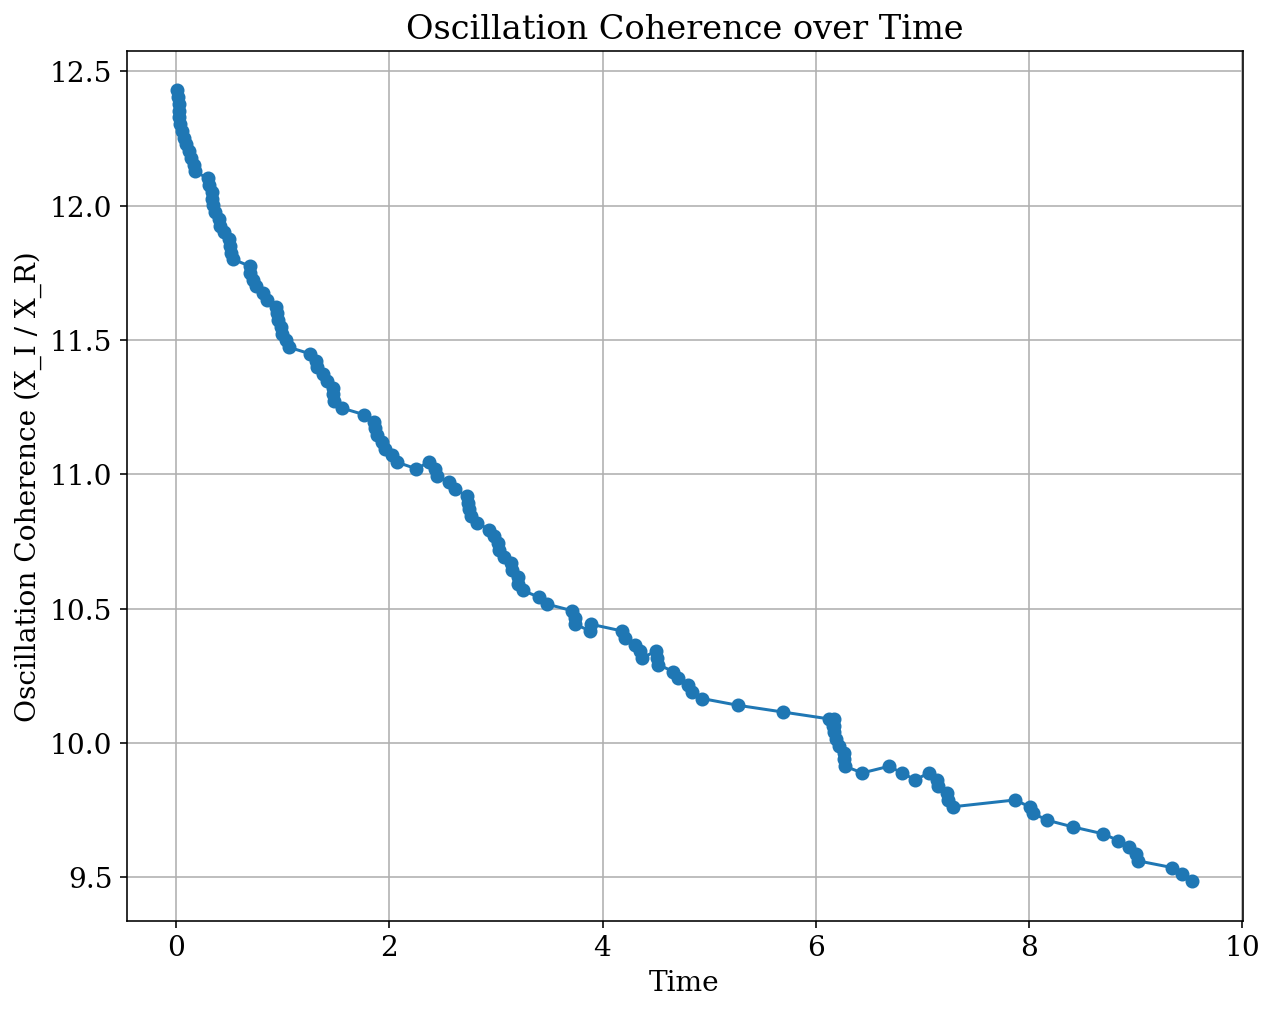

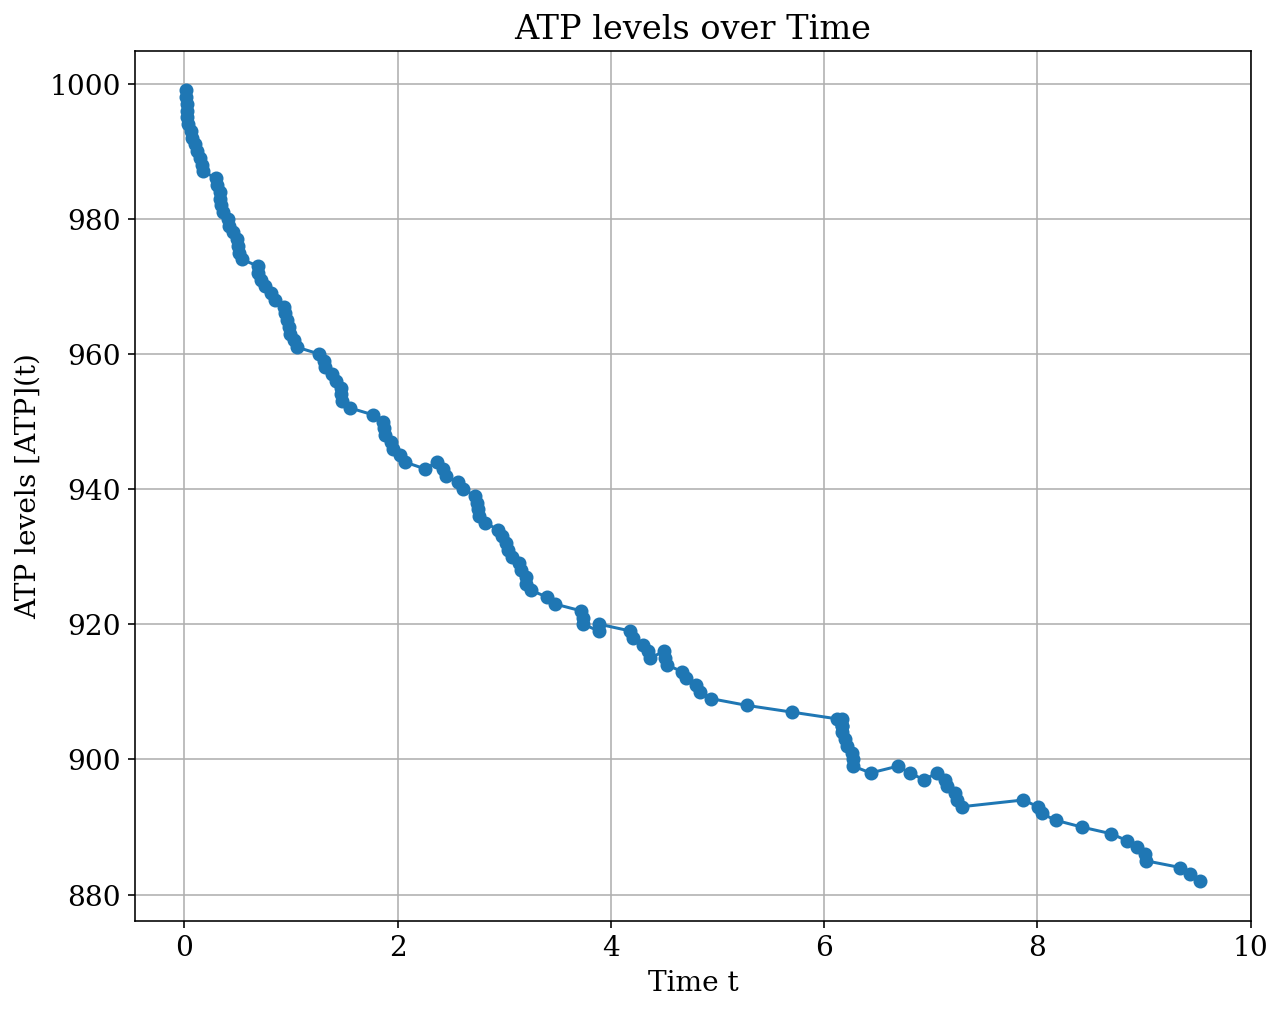

In [33]:
# Parameters
N = 40
F_init = 1.0
T_max = 10
n_ATP_init = 1000
n_ADP_init = 10
n_P = 1

# Run the 3D Gillespie simulation
trajectory, coherence_record, atp_record = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init, n_P)

# Plot the 3D trajectory
plot_trajectory_3d(trajectory)

# Plot the coherence over time
plot_coherence(coherence_record)

plot_atp(atp_record)

In [34]:
def plot_average_results(avg_times, avg_coherence, avg_atp):
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    axs[0].plot(avg_times, avg_coherence, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Average Coherence')
    axs[0].set_title('Average Oscillation Coherence over Time')
    axs[0].grid(True)

    axs[1].plot(avg_times, avg_atp, '-o')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Average ATP Levels')
    axs[1].set_title('Average ATP Levels over Time')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

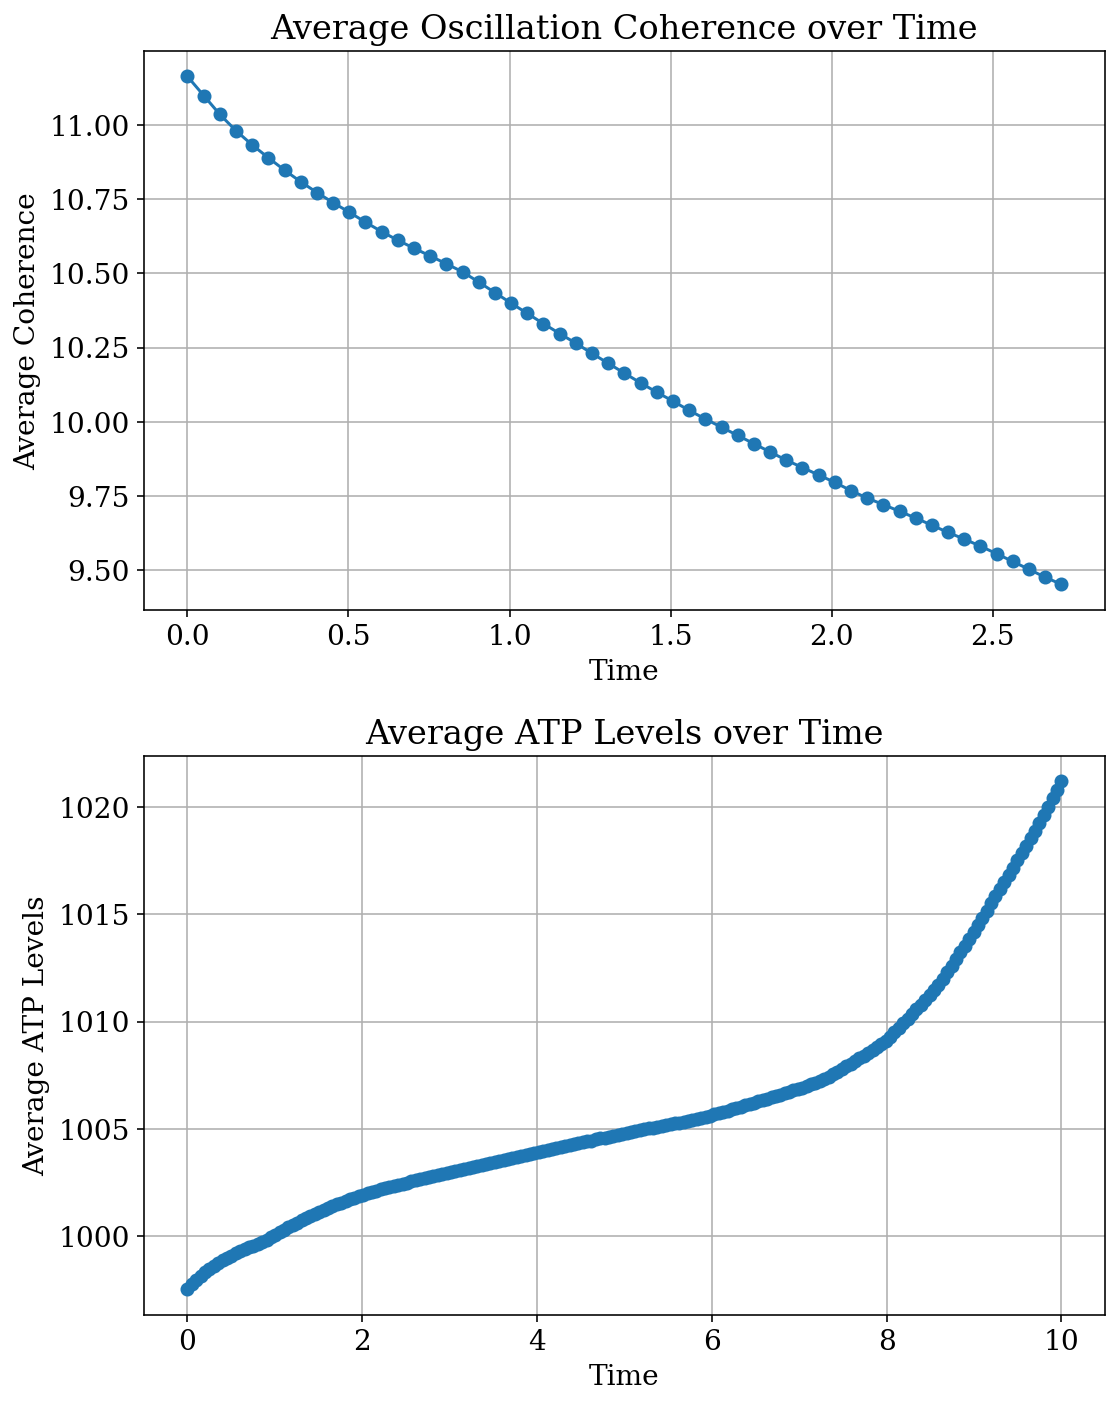

In [35]:
from scipy.interpolate import interp1d

# Parameters
N = 40
F_init = 1.0
T_max = 10
n_ATP_init = 1000
n_ADP_init = 10
n_P = 1000
n_trajectories = 1000

# Common time grid
time_grid = np.linspace(0, T_max, 200)
all_coherence_interp = []
all_atp_interp = []

for _ in range(n_trajectories):
    trajectory, coherence_record, atp_record = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init, n_P)

    times_coh, coherences = zip(*coherence_record)
    times_atp, atp_levels = zip(*atp_record)

    # Interpolate onto common time grid
    interp_coh = interp1d(times_coh, coherences, bounds_error=False, fill_value='extrapolate')
    interp_atp = interp1d(times_atp, atp_levels, bounds_error=False, fill_value='extrapolate')

    all_coherence_interp.append(interp_coh(time_grid))
    all_atp_interp.append(interp_atp(time_grid))

# Average over trajectories
avg_coherence = np.mean(all_coherence_interp, axis=0)
avg_atp = np.mean(all_atp_interp, axis=0)

# Plot averaged results
plot_average_results(time_grid, avg_coherence, avg_atp)

In [249]:
# Initialize rates in system back to A = 0 values

k_m = 1.0
A = 0.0
k_p = np.round(k_m*np.exp(A/N),4)

# Assign parameter values to the graph

edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
label_list = np.fromiter(label_dict.values(), dtype=float)
W = Laplacian_all(edge_list,label_list,node_list)
affinity = np.round(np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward)),4)

affinity
print(G[4][3]['weight'])

1.0


In [250]:
# add state variables for the number of ATP/ADP molecules in the environment
n_ATP = 100
n_ADP = 1

k_23 = G[2][3]['weight']
k_32 = G[3][2]['weight']

all_affinities = np.array([])
force_ratio = np.array([])
all_coherences = np.array([])

times = np.linspace(0.1, 5, 500)

while n_ATP > 0:
    # crudely adding 2 to the current value of the rate
    k_23 = k_23*n_ATP
    k_32 = k_32*n_ADP
    
    # change all data structures
    G[2][3]['weight'] = k_23
    G[3][2]['weight'] = k_32
    # first element in the array is edge 2->3
    edge_labels_forward[0] = k_23
    edge_labels_backward[0] = k_32
    label_dict[2,3] = k_23
    label_dict[3,2] = k_32
    label_list = np.fromiter(label_dict.values(), dtype=float)
    W = Laplacian_all(edge_list,label_list,node_list)
    
    # compute and store affinity
    affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
    all_affinities = np.append(all_affinities,affinity)
    
    # compute and store oscillation coherence
    R, x_i, x_r = oscillation_coherence(W)
    all_coherences = np.append(all_coherences,R)
    
    # deplete ATP + add ADP
    n_ATP -= 1
    n_ADP += 1
    force_ratio = np.append(force_ratio, np.log(n_ATP/n_ADP))

/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_64229/344175447.py:8: RuntimeWarning: invalid value encountered in double_scalars
  R = np.round(x_i/x_r,4)
/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_64229/935467030.py:41: RuntimeWarning: divide by zero encountered in log
  force_ratio = np.append(force_ratio, np.log(n_ATP/n_ADP))


In [251]:
k_23

9.332621544394418e+157

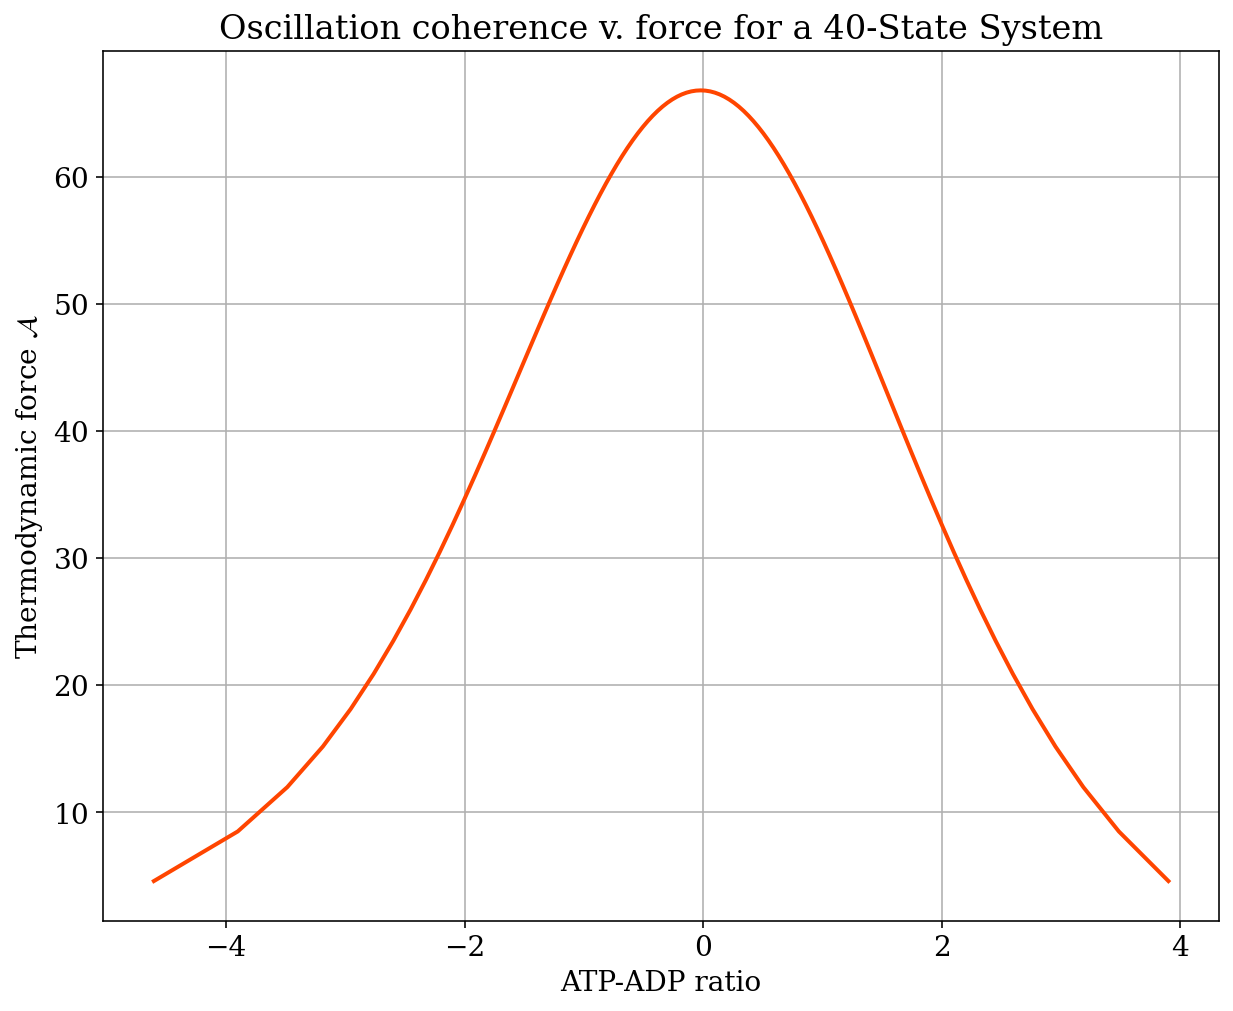

In [255]:
num_states = str(N)

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(force_ratio, all_affinities, color = "orangered", linewidth=2)
plt.ylabel(r'Thermodynamic force $\mathcal{A}$')
plt.xlabel(r'ATP-ADP ratio')
plt.title('Oscillation coherence v. force for a '+ num_states +'-State System')
plt.grid()
plt.show()

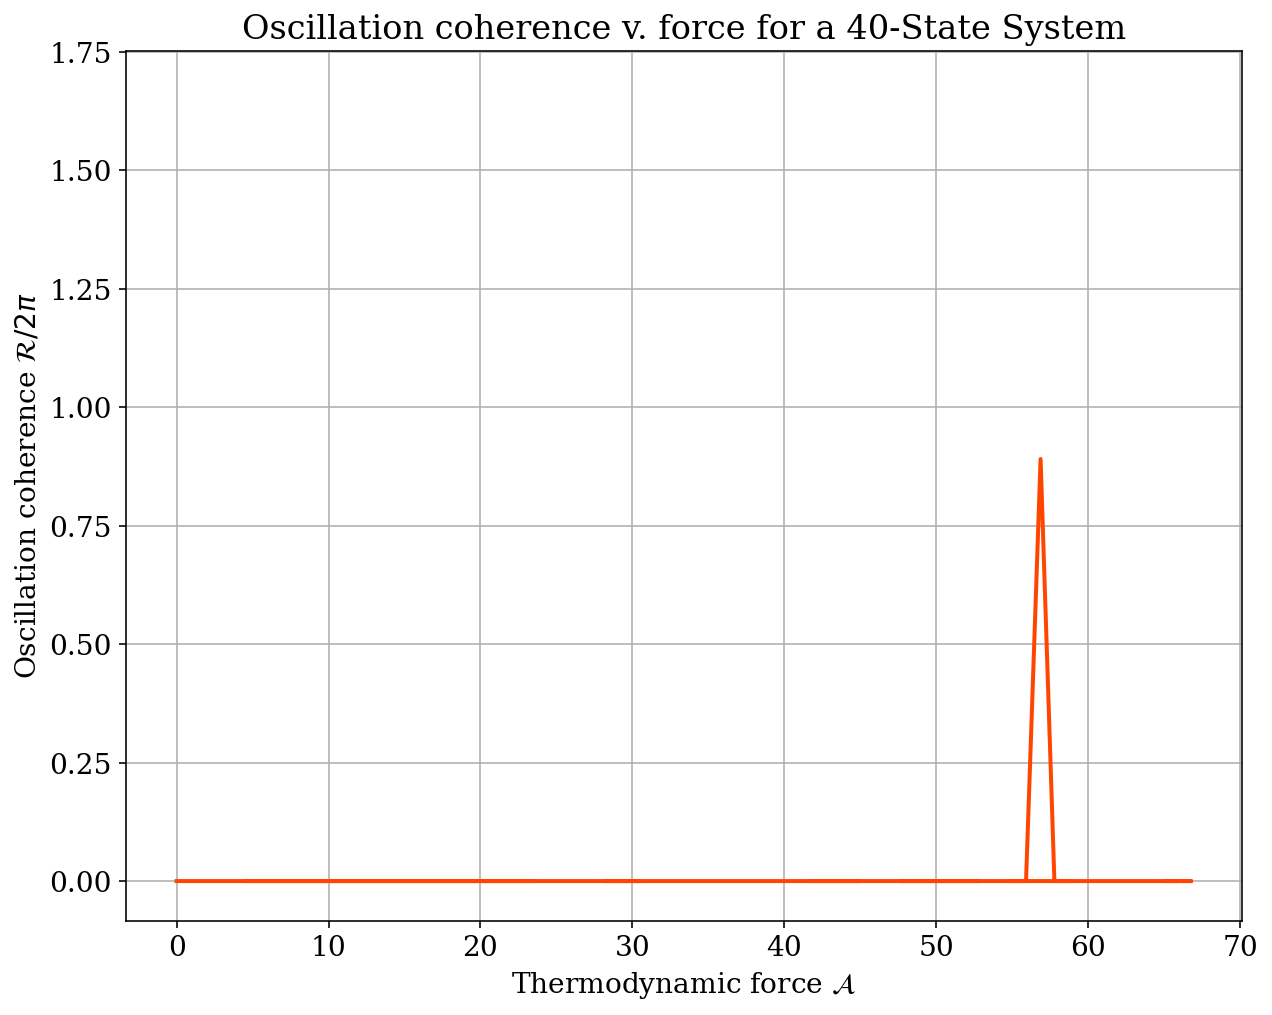

In [254]:
num_states = str(N)

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(all_affinities, all_coherences, color = "orangered", linewidth=2)
plt.xlabel(r'Thermodynamic force $\mathcal{A}$')
plt.ylabel(r'Oscillation coherence $\mathcal{R}/2 \pi$')
plt.title('Oscillation coherence v. force for a '+ num_states +'-State System')
plt.grid()
plt.show()

In [141]:
ATP = 1000
ADP = 10

#oscillator state
i = np.sort(cycle_list)[0]
# amount of ATP
n_ATP = np.arange(0,ATP)
# amount of ADP
n_ADP = np.arange(0,ADP)